In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time

from utilities2015 import *

from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import average, fcluster, single, complete

from joblib import Parallel, delayed

from skimage.color import gray2rgb
from skimage.measure import find_contours
from skimage.util import img_as_float

import matplotlib.pyplot as plt
%matplotlib inline

from networkx import from_dict_of_lists, Graph, adjacency_matrix, connected_components
from networkx.algorithms import node_connected_component, dfs_successors, dfs_postorder_nodes

In [2]:
stack_name = 'MD593'
section_id = 138
# dm = DataManager(stack=stack_name, section=section_id, segm_params_id='gridsize200')
dm = DataManager(stack=stack_name, section=section_id, segm_params_id='tSLIC200')

In [3]:
dm.load_multiple_results(results=['texHist', 'segmentation', 'texMap', 'neighbors', 
                                  'edgeCoords', 'spCentroids', 'edgeNeighbors', 'dedgeNeighbors',
                                  'spCoords'])

terminate 0.117254858115 0.100300419489


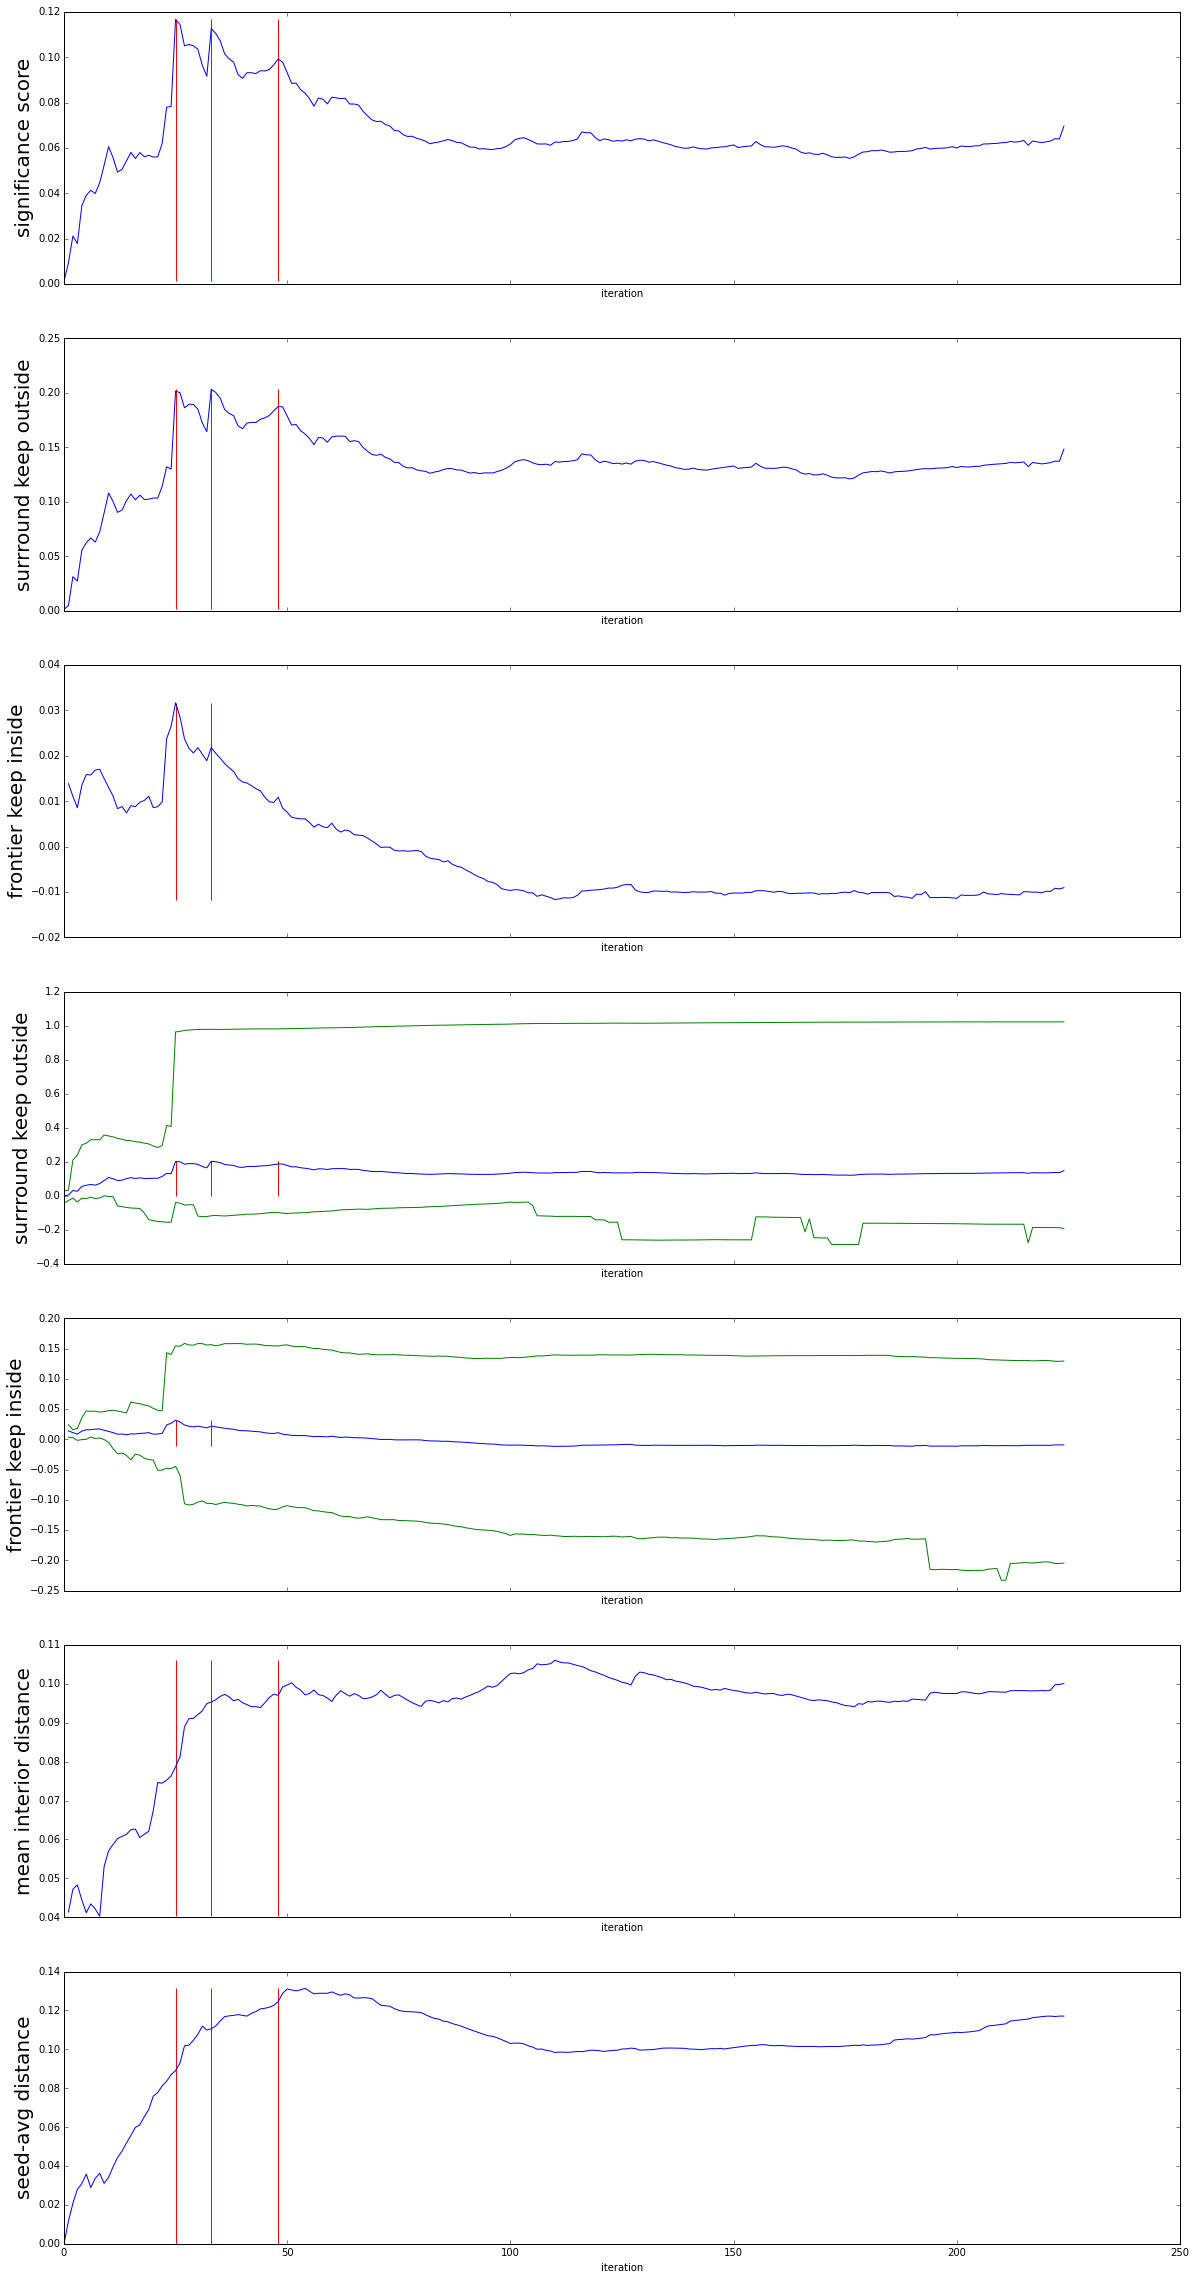

In [81]:
clusters_allhistory, score_tuples, peaks_sorted, _, _, peaks1, peaks2 = dm.grow_cluster(967,
                                                                        seed_weight=0,
                                                                        verbose=False, all_history=True, 
                                                                        num_sp_percentage_limit=0.2,
                                                                     min_size=3, min_distance=5,
                                                                        threshold_abs=-0.1,
                                                                        threshold_rel=0.02,
                                                                       peakedness_limit=.002,
                                                                       method='rc-mean')

In [66]:
peaks_sorted

array([ 5, 12, 15, 21, 40])

In [49]:
viz = dm.visualize_cluster(clusters_allhistory[22])
display(viz)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg